In [1]:
from quadtree import Board
import tensorflow as tf
# from model import DCGAN
import numpy as np
import os
from mcts_alphaZero import Game

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/mitchgu/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load dataset and declare consts

In [12]:
model_filename = "mnist.model.pb"

params = {
    'max_steps': 20000,
    'batch_size': 50,
    'log_dir': 'logs',
    'log_interval': 100, 
    'checkpoint_interval': 500
}
data_dir = "./data/mnist"

N = 50000

fd = open(os.path.join(data_dir,'th-train-images-idx3-ubyte'))
loaded = np.fromfile(file=fd,dtype=np.uint8)
trX = loaded[16:].reshape((60000,28,28,1)).astype(np.float)[:N]

# fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
# loaded = np.fromfile(file=fd,dtype=np.uint8)
# trY = loaded[8:].reshape((60000)).astype(np.float)

# fd = open(os.path.join(data_dir,'th-t10k-images-idx3-ubyte'))
# loaded = np.fromfile(file=fd,dtype=np.uint8)
# teX = loaded[16:].reshape((10000,28,28,1)).astype(np.float)

# fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
# loaded = np.fromfile(file=fd,dtype=np.uint8)
# teY = loaded[8:].reshape((10000)).astype(np.float)

# trY = np.asarray(trY)
# teY = np.asarray(teY)

trY = np.zeros((N, 10))
trY[:,0] = 1

fakeX = np.load('generation0.npy')[:N]
fakeY = np.zeros((N, 10))
fakeY[:,1] = 1

X = np.concatenate((trX, fakeX), axis=0)/255.
y = np.concatenate((trY, fakeY)).astype(np.int)
#np.concatenate((trY, teY), axis=0).astype(np.int)

seed = 547
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

# y_vec = np.zeros((len(y), self.y_dim), dtype=np.float)
# for i, label in enumerate(y):
#   y_vec[i,y[i]] = 1.0

# return X/255.,y

training_img = X[:40000]
val_img = X[:10000]

training_labels = y[:40000]
val_labels = y[:10000]

In [11]:
def get_inference_graph(model_filename):
    inference_graph = tf.Graph()
    with inference_graph.as_default():
        with tf.gfile.FastGFile(model_filename, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name="")
            
    return inference_graph

def run_inference(model_filename, images, params):
    inference_graph = get_inference_graph(model_filename)
    images_node = inference_graph.get_operation_by_name('images').outputs[0]
#     train_img = inference_graph.get_operation_by_name('mod_img').outputs[0]
    inference_node = inference_graph.get_operation_by_name('inference').outputs[0]
    
    inference = np.zeros((images.shape[0], 10))
    num_batches = images.shape[0] // params['batch_size']
    
    
    # Run a single step with 
    with tf.Session(graph=inference_graph) as sess:   
        for step in range(num_batches):
            begin = step*params['batch_size']
            end = begin + params['batch_size']
            feed_dict = { images_node: images[begin:end]}
            inference[begin:end] += sess.run(inference_node, feed_dict=feed_dict)
    inferred_labels = np.argmax(inference, axis=1)

    inferred_labels_one_hot = np.zeros((inferred_labels.shape[0], 10))
    inferred_labels_one_hot[np.arange(inferred_labels.shape[0]), inferred_labels] = 1

    return inference


In [5]:
run_inference(model_filename, val_img, params)

array([[ 12.88483334,   1.89818001,  -6.01280403, ...,  -5.77380371,
         -6.34031343,  -6.647964  ],
       [ 12.39700699,   0.67696643,  -5.41423273, ...,  -4.94531631,
         -5.80711555,  -6.0858531 ],
       [ 12.69307613,   1.37977624,  -5.62784624, ...,  -5.2978158 ,
         -5.91984463,  -6.28190136],
       ..., 
       [ 13.50880146,   1.25019026,  -6.16577291, ...,  -5.68382788,
         -6.66343212,  -6.83774137],
       [ -5.65323639,  24.46416855,  -8.57912254, ...,  -8.18227959,
         -7.40164948,  -8.15728569],
       [ 14.17021942,   0.5255776 ,  -6.12971401, ...,  -5.89715576,
         -6.59779835,  -6.88846874]])

In [9]:
def show(img):
    plt.figure()
    plt.imshow(img, cmap="Greys_r",vmin=0, vmax=255)

In [6]:
def policy_wrapper(board):
    samples = np.ones((50,28,28,1))
    samples[:,:,:,0] = board.data/255.

    r = run_inference(model_filename, samples, params)
    return np.mean(r[:,0] - r[:,1]), 0

In [16]:
image = Board(28,28)
game = Game(policy_wrapper, 1, 100)
print(policy_wrapper(image)[0])

6.43855667114


6.43855667114
-12.2486923635
-6.63161683083
-1.85705184937
1.15255260468
-0.935413837433
9.92638671398
8.27636384964
6.4984164238
7.89592647552
8.09227252007
6.35356140137
6.67751121521
8.80120229721
9.01358938217
6.41407728195
4.50340557098
3.3906288147


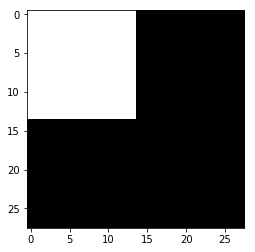

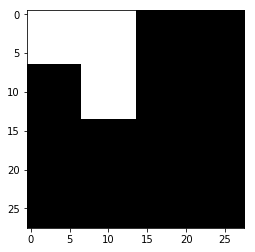

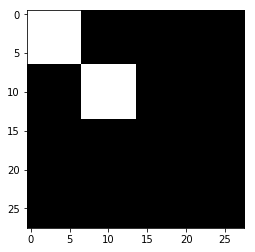

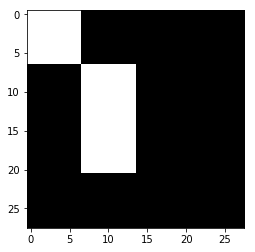

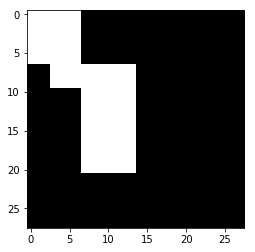

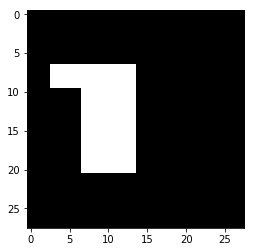

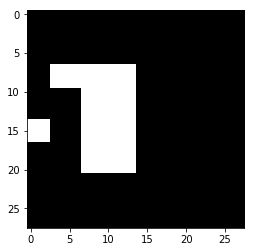

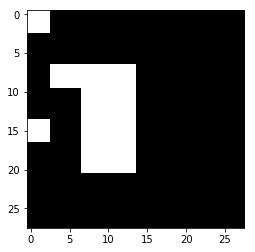

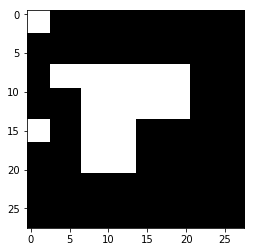

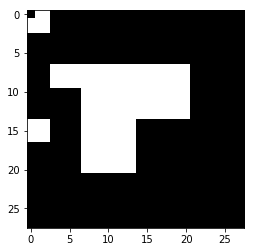

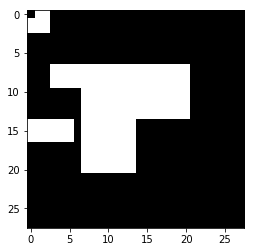

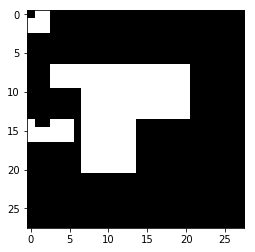

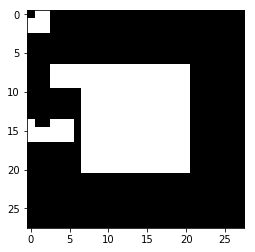

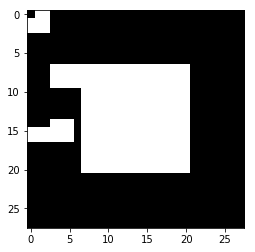

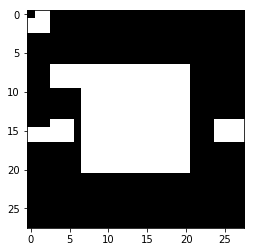

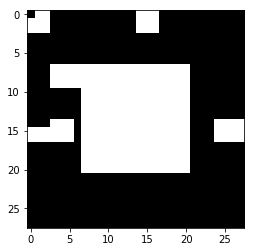

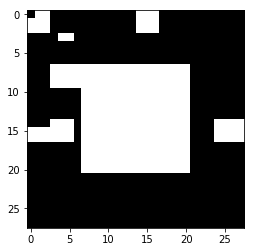

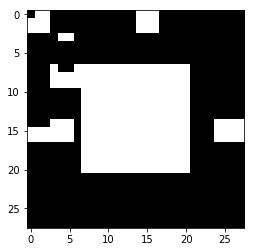

In [17]:
for i in range(18):
    print(policy_wrapper(image)[0])
    game.step(image)
    show(image.data)
    plt.savefig("tmp/anim{}.png".format(i))